In [1]:
# Librerias 

import os
import gc
import re
import unicodedata
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

import nltk
from nltk import TweetTokenizer
from nltk.util import ngrams

import spacy
from spacy.lang.en import English

from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from tqdm import tqdm
from sklearn.model_selection import train_test_split
# Asegúrate de tener instaladas las siguientes bibliotecas:
# !pip install torch transformers scikit-learn imbalanced-learn spacy tqdm nltk

# Configuración de NLTK y SpaCy
nltk.download('punkt')
spacy.cli.download("en_core_web_sm")

# Habilitar recolección de basura
gc.enable()

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 71.8 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Configuración del modelo
config = {
    'batch_size': 8, #8
    'best_pretrained_roberta_folder':  'j-hartmann/emotion-english-distilroberta-base',#Jorgeutd/sagemaker-roberta-base-emotion',  #'j-hartmann/emotion-english-distilroberta-base',
    'lr': 2e-5, 
    'num_of_epochs': 100,
    'seed': 2021,
    'sentence_max_length': 400,
    'wd': 0.01
}


# Definir dispositivo
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

Device: cpu


In [3]:
import os
import sys
PATH = os.getcwd()
DIR_DATA = PATH + '{0}data{0}'.format(os.sep)
sys.path.append(PATH) if PATH not in list(sys.path) else None
DIR_DATA

'/home/ubuntu/danileth_old/SemEval2025/data/'

In [4]:
train_csv_path = DIR_DATA +'combined_data.xlsx'

# Cargar datos
df_combined_data = pd.read_excel(train_csv_path)


# Crear una copia del DataFrame con solo las columnas 'id', 'text' y las emociones
train_data = df_combined_data[['id', 'text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].copy()
print(f'The total # of samples is {len(train_data)}.')


The total # of samples is 7597.


In [5]:
# Crear otro DataFrame con las primeras 100 filas de train_data

#train_data = train_data2.iloc[:102].copy()

# Mostrar los primeros 100 datos al usuario
train_data

,id,text,Anger,Fear,Joy,Sadness,Surprise
0,eng_train_track_a_00001,But not very happy.,0,0,1,1,0
1,eng_train_track_a_00002,Well she's not gon na last the whole song like...,0,0,1,0,0
2,eng_train_track_a_00003,She sat at her Papa's recliner sofa only to mo...,0,0,0,0,0
3,eng_train_track_a_00004,"Yes, the Oklahoma city bombing.",1,1,0,1,1
4,eng_train_track_a_00005,They were dancing to Bolero.,0,0,1,0,0
...,...,...,...,...,...,...,...
7592,ptbr_train_track_a_02222,I think CAP will surprise you.,0,0,0,0,1
7593,ptbr_train_track_a_02223,23:59 - Lula knew about all the corruption in ...,1,0,0,0,0
7594,ptbr_train_track_a_02224,Brazil URGENTLY needs people who are serious a...,1,0,0,0,0
7595,ptbr_train_track_a_02225,Am I the only one who thinks it's time to impe...,1,0,0,0,0


In [6]:


# Cargar el idioma inglés de spaCy para la lematización y noun chunks
nlp = spacy.load('en_core_web_sm')

class TextProcessing(object):
    name = 'Text Processing'
    lang = 'en'

    def __init__(self, lang: str = 'en'):
        self.lang = lang

    @staticmethod
    def nlp(text: str) -> list:
        try:
            list_tagger = []
            tp_nlp = TextProcessing.load_spacy(TextProcessing.lang)
            doc = tp_nlp(text.lower())
            for token in doc:
                item = {'text': token.text, 'lemma': token.lemma_, 'pos': token.pos_, 'tag': token.tag_,
                        'dep': token.dep_, 'shape': token.shape_, 'is_alpha': token.is_alpha,
                        'is_stop': token.is_stop, 'is_digit': token.is_digit, 'is_punct': token.is_punct}
                list_tagger.append(item)
            return list_tagger
        except Exception as e:
            print('Error nlp: {0}'.format(e))

    @staticmethod
    def load_spacy(lang: str) -> object:
        try:
            spacy_model = {'en': 'en_core_web_sm'}
            if not spacy.util.is_package(spacy_model[lang]):
                spacy.cli.download(spacy_model[lang])

            component = spacy.load(spacy_model[lang])
            return component
        except Exception as e:
            print('Error load spacy: {0}'.format(e))

    @staticmethod
    def proper_encoding(text: str) -> str:
        if not isinstance(text, str):
            return ''  # Return an empty string or handle it as needed
        try:
            text = unicodedata.normalize('NFD', text)
            text = text.encode('ascii', 'ignore')
            return text.decode("utf-8")
        except Exception as e:
            print('Error proper_encoding: {0}'.format(e))
            return text  # Return the original text in case of error

    @staticmethod
    def stopwords(text: str) -> str:
        if not isinstance(text, str):
            return ''  # Return an empty string or handle it as needed
        try:
            nlp = spacy.load('en_core_web_sm')
            doc = nlp(text)
            token_list = [token.text for token in doc]
            sentence = []
            for word in token_list:
                lexeme = nlp.vocab[word]
                if not lexeme.is_stop:
                    sentence.append(word)
            return ' '.join(sentence)
        except Exception as e:
            print('Error stopwords: {0}'.format(e))
            return text  # Return the original text in case of error

    @staticmethod
    def remove_patterns(text: str) -> str:
        if not isinstance(text, str):
            return ''  # Return an empty string or handle it as needed
        try:
            text = re.sub(r'\©|\×|\⇔|\_|\»|\«|\~|\#|\$|\€|\Â|\�|\¬', '', text)
            text = re.sub(r'\,|\;|\:|\!|\¡|\’|\‘|\”|\“|\"|\'|\`', '', text)
            text = re.sub(r'\}|\{|\[|\]|\(|\)|\<|\>|\?|\¿|\°|\|', '', text)
            text = re.sub(r'\/|\-|\+|\*|\=|\^|\%|\&|\$', '', text)
            text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)
            return text.lower()
        except Exception as e:
            print('Error remove_patterns: {0}'.format(e))
            return text  # Return the original text in case of error

    @staticmethod
    def transformer(text: str, stopwords: bool = False) -> str:
        if not isinstance(text, str):
            return ''  # Return an empty string or handle it as needed
        try:
            text_out = TextProcessing.proper_encoding(text)
            text_out = text_out.lower()
            text_out = re.sub("[\U0001f000-\U000e007f]", '[EMOJI]', text_out)
            text_out = re.sub(
                r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+'
                r'|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))',
                '[URL]', text_out)
            text_out = re.sub("@([A-Za-z0-9_]{1,40})", '[MENTION]', text_out)
            text_out = re.sub("#([A-Za-z0-9_]{1,40})", '[HASTAG]', text_out)
            text_out = TextProcessing.remove_patterns(text_out)
            text_out = TextProcessing.stopwords(text_out) if stopwords else text_out
            text_out = re.sub(r'\s+', ' ', text_out).strip()
            return text_out if text_out != ' ' else None
        except Exception as e:
            print('Error transformer: {0}'.format(e))
            return text  # Return the original text in case of error

    @staticmethod
    def tokenizer(text: str) -> list:
        if not isinstance(text, str):
            return []  # Return an empty list or handle it as needed
        try:
            text_tokenizer = TweetTokenizer()
            return text_tokenizer.tokenize(text)
        except Exception as e:
            print('Error tokenizer: {0}'.format(e))
            return []  # Return an empty list in case of error

    @staticmethod
    def make_ngrams(text: str, num: int):
        if not isinstance(text, str):
            return []  # Return an empty list or handle it as needed
        try:
            n_grams = ngrams(nltk.word_tokenize(text), num)
            return [' '.join(grams) for grams in n_grams]
        except Exception as e:
            print('Error make_ngrams: {0}'.format(e))
            return []  # Return an empty list in case of error

# Crear una instancia de TextProcessing para inglés
tp_en = TextProcessing(lang='en')

# Aplicar el preprocesamiento a los textos del DataFrame
train_data['text'] = train_data['text'].apply(lambda x: tp_en.transformer(x))


train_data

,id,text,Anger,Fear,Joy,Sadness,Surprise
0,eng_train_track_a_00001,but not very happy.,0,0,1,1,0
1,eng_train_track_a_00002,well shes not gon na last the whole song like ...,0,0,1,0,0
2,eng_train_track_a_00003,she sat at her papas recliner sofa only to mov...,0,0,0,0,0
3,eng_train_track_a_00004,yes the oklahoma city bombing.,1,1,0,1,1
4,eng_train_track_a_00005,they were dancing to bolero.,0,0,1,0,0
...,...,...,...,...,...,...,...
7592,ptbr_train_track_a_02222,i think cap will surprise you.,0,0,0,0,1
7593,ptbr_train_track_a_02223,lula knew about all the corruption in his gove...,1,0,0,0,0
7594,ptbr_train_track_a_02224,brazil urgently needs people who are serious a...,1,0,0,0,0
7595,ptbr_train_track_a_02225,am i the only one who thinks its time to impea...,1,0,0,0,0


In [7]:
# Dividir los datos en entrenamiento y prueba
trainset, testset = train_test_split(train_data, test_size=0.2, random_state=2024)

# Calcular pesos de las clases (como en tu código original)
class_weights = trainset[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].sum(axis=0) / trainset[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].sum().sum()
class_weights = max(class_weights) / class_weights
# Ahora estos pesos se usarán como pos_weight en BCEWithLogitsLoss
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float).to(device)
print(f"Class weights: {class_weights}")

Class weights: Anger       1.069246
Fear        1.000000
Joy         1.114650
Sadness     1.128223
Surprise    1.689914
dtype: float64


In [8]:
# Tokenizador
tokenizer = RobertaTokenizer.from_pretrained(config['best_pretrained_roberta_folder'])
print('Tokenizer loaded.')

# Dataset personalizado
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, targets):
        self.encodings = encodings
        self.targets = targets.values

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['target'] = torch.tensor(self.targets[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.targets)


Tokenizer loaded.


In [9]:
# Crear DataLoader
def create_dataloader(texts, targets, batch_size, shuffle=True):
    encodings = tokenizer(
        list(texts),
        max_length=config['sentence_max_length'],
        truncation=True,
        padding=True,
        return_tensors='pt'
    )
    dataset = EmotionDataset(encodings, targets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Modelo RoBERTa con atención y capas personalizadas
class EmotionRobertaModel(nn.Module):
    def __init__(self):
        super(EmotionRobertaModel, self).__init__()
        self.config = RobertaConfig.from_pretrained(config['best_pretrained_roberta_folder'])
        self.config.output_hidden_states = True
        self.num_labels = 5
        self.roberta = RobertaModel.from_pretrained(config['best_pretrained_roberta_folder'], config=self.config)
        self.classifier = nn.Linear(self.config.hidden_size, self.num_labels)
        self.dropout = nn.Dropout(0.1)

    def forward(self, tokens, attention_mask):
        # Ya no aplicamos sigmoid aquí. Devolvemos logits directos.
        outputs = self.roberta(tokens, attention_mask=attention_mask)[0]
        pooled_output = torch.mean(outputs, dim=1)
        logits = self.classifier(self.dropout(pooled_output))
        return logits  # Sin sigmoid, porque usaremos BCEWithLogitsLoss

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.metrics import classification_report

class RobertaEstimatorWithWeights(BaseEstimator, ClassifierMixin):
    def __init__(self, model, device, lr=config['lr'], wd=config['wd'], num_epochs=config['num_of_epochs'], batch_size=config['batch_size'], class_weights=None):
        self.model = model
        self.device = device
        self.lr = lr
        self.wd = wd
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.class_weights = class_weights
        # Almacenar las métricas
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.val_precisions_micro = []
        self.val_precisions_macro = []
        self.val_recalls_micro = []
        self.val_recalls_macro = []
        self.val_f1s_micro = []
        self.val_f1s_macro = []

    def fit(self, X, y):
        train_loader = create_dataloader(X['text'], y, self.batch_size, shuffle=True)
        val_loader = create_dataloader(X['text'], y, self.batch_size, shuffle=False)
        
        self.model.to(self.device)
        self.optimizer = AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
        self.model.train()

        # Usar BCEWithLogitsLoss con pos_weight para el balanceo (como en el ejemplo)
        criterion = nn.BCEWithLogitsLoss(pos_weight=self.class_weights)

        for epoch in range(self.num_epochs):
            print(f"\nEpoch {epoch + 1}/{self.num_epochs}")
            total_loss = 0
            for batch in tqdm(train_loader):
                inputs = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                targets = batch['target'].to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs, attention_mask)
                loss = criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            avg_train_loss = total_loss / len(train_loader)
            self.train_losses.append(avg_train_loss)
            print(f"Training Loss: {avg_train_loss:.4f}")

            # Validación
            self.model.eval()
            all_predictions, all_targets = [], []
            val_loss_total = 0
            with torch.no_grad():
                for batch in val_loader:
                    inputs = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    targets_batch = batch['target'].to(self.device)
                    outputs = self.model(inputs, attention_mask)
                    val_loss = criterion(outputs, targets_batch)
                    val_loss_total += val_loss.item()

                    # Aplicar sigmoid para obtener probabilidades antes de thresholding
                    predictions = torch.sigmoid(outputs)
                    preds = predictions.cpu().numpy()
                    targs = targets_batch.cpu().numpy()

                    all_predictions.append(preds)
                    all_targets.append(targs)

            avg_val_loss = val_loss_total / len(val_loader)
            self.val_losses.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")

            # Calcular las métricas
            all_predictions = np.vstack(all_predictions)
            all_targets = np.vstack(all_targets)

            all_predictions_binary = (all_predictions > 0.5).astype(int)

            # Micro métricas
            accuracy = accuracy_score(all_targets, all_predictions_binary)
            precision_micro = precision_score(all_targets, all_predictions_binary, average='micro', zero_division=0)
            recall_micro = recall_score(all_targets, all_predictions_binary, average='micro')
            f1_micro = f1_score(all_targets, all_predictions_binary, average='micro')

            # Macro métricas
            precision_macro = precision_score(all_targets, all_predictions_binary, average='macro', zero_division=0)
            recall_macro = recall_score(all_targets, all_predictions_binary, average='macro')
            f1_macro = f1_score(all_targets, all_predictions_binary, average='macro')

            # Almacenar métricas
            self.val_accuracies.append(accuracy)
            self.val_precisions_micro.append(precision_micro)
            self.val_precisions_macro.append(precision_macro)
            self.val_recalls_micro.append(recall_micro)
            self.val_recalls_macro.append(recall_macro)
            self.val_f1s_micro.append(f1_micro)
            self.val_f1s_macro.append(f1_macro)

            print(f"Validation Accuracy: {accuracy:.4f}")
            print(f"Micro - Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1-Score: {f1_micro:.4f}")
            print(f"Macro - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-Score: {f1_macro:.4f}")

            self.model.train()

        # Promedios finales después de todas las épocas
        average_train_loss = sum(self.train_losses) / len(self.train_losses)
        average_val_loss = sum(self.val_losses) / len(self.val_losses)
        average_accuracy = sum(self.val_accuracies) / len(self.val_accuracies)
        average_precision_micro = sum(self.val_precisions_micro) / len(self.val_precisions_micro)
        average_precision_macro = sum(self.val_precisions_macro) / len(self.val_precisions_macro)
        average_recall_micro = sum(self.val_recalls_micro) / len(self.val_recalls_micro)
        average_recall_macro = sum(self.val_recalls_macro) / len(self.val_recalls_macro)
        average_f1_micro = sum(self.val_f1s_micro) / len(self.val_f1s_micro)
        average_f1_macro = sum(self.val_f1s_macro) / len(self.val_f1s_macro)

        print("\nPromedio de pérdida de entrenamiento en todas las épocas:", average_train_loss)
        print("Promedio de pérdida de validación en todas las épocas:", average_val_loss)
        print("Promedio de Exactitud de Validación en todas las épocas:", average_accuracy)
        print("Micro Promedio - Precisión:", average_precision_micro, "Recall:", average_recall_micro, "F1-Score:", average_f1_micro)
        print("Macro Promedio - Precisión:", average_precision_macro, "Recall:", average_recall_macro, "F1-Score:", average_f1_macro)

        return self

    def predict(self, X):
        self.model.eval()
        loader = create_dataloader(X['text'], pd.DataFrame(np.zeros((len(X), 5)), columns=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']), self.batch_size, shuffle=False)
        all_predictions = []
        with torch.no_grad():
            for batch in loader:
                inputs = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                outputs = self.model(inputs, attention_mask)
                # Aplicar sigmoid antes de thresholding
                preds = torch.sigmoid(outputs)
                all_predictions.append((preds > 0.5).cpu().numpy())
        return np.vstack(all_predictions)

# Crear pipeline con pesos
text_clf = SklearnPipeline([
    ('model', RobertaEstimatorWithWeights(model=EmotionRobertaModel(), device=device, lr=config['lr'], wd=config['wd'], num_epochs=config['num_of_epochs'], batch_size=config['batch_size'], class_weights=class_weights_tensor))
])

# Ajustar el modelo
text_clf.fit(trainset, trainset[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']])

# Evaluar el modelo en el testset
#predictions = text_clf.predict(testset)
#print("Reporte de clasificación:")
#print(classification_report(testset[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].values, predictions, zero_division=0))


Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [1:10:28<00:00,  5.56s/it]


Training Loss: 0.4223
Validation Loss: 0.3120
Validation Accuracy: 0.5496
Micro - Precision: 0.7739, Recall: 0.6832, F1-Score: 0.7257
Macro - Precision: 0.7796, Recall: 0.6827, F1-Score: 0.7197

Epoch 2/10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [1:11:24<00:00,  5.64s/it]


Training Loss: 0.3277
Validation Loss: 0.2203
Validation Accuracy: 0.6806
Micro - Precision: 0.8535, Recall: 0.8066, F1-Score: 0.8294
Macro - Precision: 0.8559, Recall: 0.8060, F1-Score: 0.8289

Epoch 3/10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [1:10:52<00:00,  5.60s/it]


Training Loss: 0.2504
Validation Loss: 0.1441
Validation Accuracy: 0.7971
Micro - Precision: 0.9167, Recall: 0.8805, F1-Score: 0.8983
Macro - Precision: 0.9163, Recall: 0.8847, F1-Score: 0.8995

Epoch 4/10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [1:11:27<00:00,  5.64s/it]


Training Loss: 0.1834
Validation Loss: 0.0966
Validation Accuracy: 0.8687
Micro - Precision: 0.9498, Recall: 0.9203, F1-Score: 0.9348
Macro - Precision: 0.9505, Recall: 0.9232, F1-Score: 0.9357

Epoch 5/10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [1:11:20<00:00,  5.63s/it]


Training Loss: 0.1331
Validation Loss: 0.0612
Validation Accuracy: 0.9271
Micro - Precision: 0.9844, Recall: 0.9467, F1-Score: 0.9652
Macro - Precision: 0.9857, Recall: 0.9477, F1-Score: 0.9662

Epoch 6/10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [1:10:42<00:00,  5.58s/it]


Training Loss: 0.0955
Validation Loss: 0.0425
Validation Accuracy: 0.9534
Micro - Precision: 0.9802, Recall: 0.9764, F1-Score: 0.9783
Macro - Precision: 0.9808, Recall: 0.9777, F1-Score: 0.9792

Epoch 7/10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [1:11:35<00:00,  5.65s/it]


Training Loss: 0.0707
Validation Loss: 0.0304
Validation Accuracy: 0.9669
Micro - Precision: 0.9847, Recall: 0.9844, F1-Score: 0.9845
Macro - Precision: 0.9848, Recall: 0.9852, F1-Score: 0.9849

Epoch 8/10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [1:11:42<00:00,  5.66s/it]


Training Loss: 0.0559
Validation Loss: 0.0184
Validation Accuracy: 0.9858
Micro - Precision: 0.9956, Recall: 0.9912, F1-Score: 0.9934
Macro - Precision: 0.9952, Recall: 0.9916, F1-Score: 0.9934

Epoch 9/10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [1:11:35<00:00,  5.65s/it]


Training Loss: 0.0408
Validation Loss: 0.0202
Validation Accuracy: 0.9799
Micro - Precision: 0.9878, Recall: 0.9938, F1-Score: 0.9908
Macro - Precision: 0.9885, Recall: 0.9941, F1-Score: 0.9912

Epoch 10/10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [1:11:45<00:00,  5.66s/it]


Training Loss: 0.0355
Validation Loss: 0.0163
Validation Accuracy: 0.9822
Micro - Precision: 0.9958, Recall: 0.9876, F1-Score: 0.9917
Macro - Precision: 0.9951, Recall: 0.9881, F1-Score: 0.9915

Promedio de pérdida de entrenamiento en todas las épocas: 0.1615344111370781
Promedio de pérdida de validación en todas las épocas: 0.0962093759453733
Promedio de Exactitud de Validación en todas las épocas: 0.8691459601777194
Micro Promedio - Precisión: 0.9422448368329978 Recall: 0.9170717336868466 F1-Score: 0.9292095388752347
Macro Promedio - Precisión: 0.943223455991645 Recall: 0.9181115900257044 F1-Score: 0.9290154082598446


Pipeline(steps=[('model',
                 RobertaEstimatorWithWeights(class_weights=tensor([1.0692, 1.0000, 1.1146, 1.1282, 1.6899]),
                                             device=device(type='cpu'),
                                             model=EmotionRobertaModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Em...
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (pooler): RobertaPooler(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (activation): Tanh()
    )
  )
  (classifier): Linear(in_features=768, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)))])

In [11]:
print("\n--- Validación en el testset con balanceo ---")

# 1. Calcular pesos de las clases basados en testset
class_weights_test = testset[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].sum(axis=0) / testset[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].sum().sum()
class_weights_test = max(class_weights_test) / class_weights_test
class_weights_test_tensor = torch.tensor(class_weights_test.values, dtype=torch.float).to(device)
print(f"Class weights para test set: {class_weights_test}")

# 2. Crear DataLoader para testset
test_loader = create_dataloader(testset['text'], testset[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']], config['batch_size'], shuffle=False)

# 3. Definir la función de pérdida con pos_weight basado en testset
criterion_test = nn.BCEWithLogitsLoss(pos_weight=class_weights_test_tensor)

# 4. Realizar predicción y calcular pérdida y métricas
model_step = text_clf.named_steps['model']

model_step.model.to(device)
model_step.model.eval()

test_loss_total = 0
all_predictions, all_targets = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluando Testset"):
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets_batch = batch['target'].to(device)
        outputs = model_step.model(inputs, attention_mask)
        loss = criterion_test(outputs, targets_batch)
        test_loss_total += loss.item()

        # Aplicar sigmoid para obtener probabilidades antes de thresholding
        predictions = torch.sigmoid(outputs)
        preds = predictions.cpu().numpy()
        targs = targets_batch.cpu().numpy()

        all_predictions.append(preds)
        all_targets.append(targs)

# Calcular métricas
avg_test_loss = test_loss_total / len(test_loader)
print(f"Pérdida promedio en testset: {avg_test_loss:.4f}")

all_predictions = np.vstack(all_predictions)
all_targets = np.vstack(all_targets)

all_predictions_binary = (all_predictions > 0.5).astype(int)

# Calcular métricas Micro
accuracy = accuracy_score(all_targets, all_predictions_binary)
precision_micro = precision_score(all_targets, all_predictions_binary, average='micro', zero_division=0)
recall_micro = recall_score(all_targets, all_predictions_binary, average='micro')
f1_micro = f1_score(all_targets, all_predictions_binary, average='micro')

# Calcular métricas Macro
precision_macro = precision_score(all_targets, all_predictions_binary, average='macro', zero_division=0)
recall_macro = recall_score(all_targets, all_predictions_binary, average='macro')
f1_macro = f1_score(all_targets, all_predictions_binary, average='macro')

# Imprimir las métricas
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Micro - Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1-Score: {f1_micro:.4f}")
print(f"Macro - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-Score: {f1_macro:.4f}")

# Reporte de clasificación
print("Reporte de clasificación en testset con pos_weight basado en testset:")
print(classification_report(
    all_targets,
    all_predictions_binary,
    zero_division=0,
    target_names=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
))


--- Validación en el testset con balanceo ---
Class weights para test set: Anger       1.109827
Fear        1.000000
Joy         1.002611
Sadness     1.200000
Surprise    1.753425
dtype: float64


Evaluando Testset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [03:04<00:00,  1.03it/s]

Pérdida promedio en testset: 0.6885
Test Loss: 0.6885
Test Accuracy: 0.4704
Micro - Precision: 0.6883, Recall: 0.5841, F1-Score: 0.6320
Macro - Precision: 0.6906, Recall: 0.5839, F1-Score: 0.6235
Reporte de clasificación en testset con pos_weight basado en testset:
              precision    recall  f1-score   support

       Anger       0.75      0.53      0.62       346
        Fear       0.69      0.71      0.70       384
         Joy       0.73      0.58      0.65       383
     Sadness       0.75      0.46      0.57       320
    Surprise       0.53      0.64      0.58       219

   micro avg       0.69      0.58      0.63      1652
   macro avg       0.69      0.58      0.62      1652
weighted avg       0.70      0.58      0.63      1652
 samples avg       0.48      0.46      0.46      1652



Matriz de confusión (en texto):
[[523  64  52  15  29]
 [ 54 233  16  14  10]
 [ 88  33 198  11  15]
 [ 43  19   6  40   2]
 [ 18  14   8   2  13]]

Matriz de confusión con etiquetas:
          Anger  Fear  Joy  Sadness  Surprise
Anger       523    64   52       15        29
Fear         54   233   16       14        10
Joy          88    33  198       11        15
Sadness      43    19    6       40         2
Surprise     18    14    8        2        13


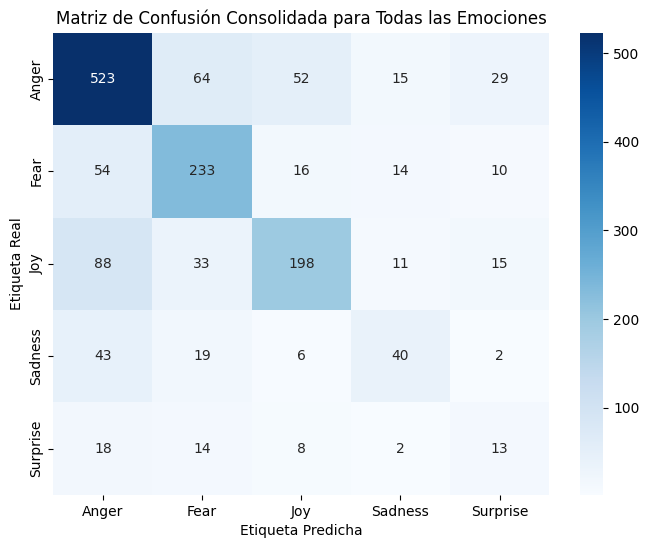

In [12]:
# ====================================================
# MATRIZ DE CONFUSIÓN CONSOLIDADA
# ====================================================

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir predicciones y targets a una sola etiqueta por muestra (argmax)
test_true = testset[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].values
test_pred = all_predictions_binary

pred_labels = np.argmax(test_pred, axis=1)
true_labels = np.argmax(test_true, axis=1)

emotion_labels = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

# Calcular matriz de confusión
cm = confusion_matrix(true_labels, pred_labels)

# Mostrar matriz de confusión como texto
print("Matriz de confusión (en texto):")
print(cm)

# Matriz de confusión con etiquetas
print("\nMatriz de confusión con etiquetas:")
print(pd.DataFrame(cm, index=emotion_labels, columns=emotion_labels))

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Matriz de Confusión Consolidada para Todas las Emociones')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()



In [13]:
# ====================================================
# PREDICCIÓN EN EL CONJUNTO DE DESARROLLO (DEV)
# ====================================================

import os
import pandas as pd

# Ruta al conjunto de desarrollo
dev_path = 'eng_a.csv'
dev = pd.read_csv(dev_path)

# Realizar predicciones en el conjunto de desarrollo
dev_predictions = text_clf.predict(dev)

# Crear DataFrame con las emociones predichas
predicted_emotions = pd.DataFrame(
    dev_predictions,
    columns=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
)

# Concatenar con el ID
submission_df = pd.concat([dev['id'], predicted_emotions], axis=1)
submission_df.rename(columns={
    'Anger': 'ira',
    'Fear': 'miedo',
    'Joy': 'alegría',
    'Sadness': 'tristeza',
    'Surprise': 'sorpresa'
}, inplace=True)

# Guardar el archivo de predicciones
output_csv_path = DIR_DATA + 'pred_eng_a3.csv'
submission_df.to_csv(output_csv_path, index=False)

print(f"\nArchivo de predicciones guardado en: {output_csv_path}")






Archivo de predicciones guardado en: /home/ubuntu/danileth_old/SemEval2025/data/pred_eng_a3.csv


/home/ubuntu/.local/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


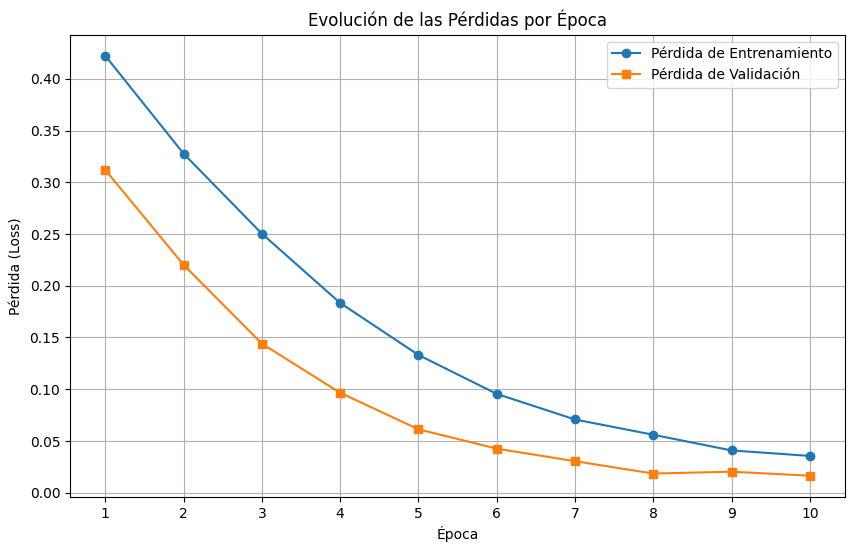

In [14]:
# (7) Graficar pérdidas de entrenamiento y validación
import matplotlib.pyplot as plt

train_losses = model_step.train_losses
val_losses = model_step.val_losses

plt.figure(figsize=(10, 6))
plt.plot(range(1, config['num_of_epochs'] + 1), train_losses, marker='o', label='Pérdida de Entrenamiento')
plt.plot(range(1, config['num_of_epochs'] + 1), val_losses, marker='s', label='Pérdida de Validación')
plt.title('Evolución de las Pérdidas por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida (Loss)')
plt.xticks(range(1, config['num_of_epochs'] + 1))
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import joblib

# Guarda el modelo entrenado en un archivo .pkl
joblib.dump(text_clf, 'modelo_entrenado.pkl')



['modelo_entrenado.pkl']